# Homework 3: Mining Data Streams

This notebook implements and evaluates the **TRIÈST-BASE** and **TRIÈST-IMPR** algorithms as described in the paper "TRIÈST: Counting Local and Global Triangles in Fully-Dynamic Streams with Fixed Memory Size."

## Dataset: Stanford Web Graph (`web-Stanford.txt`)

The experiment is run on the `web-Stanford` dataset.

> Nodes represent pages from Stanford University (stanford.edu) and directed edges represent hyperlinks between them. The data was collected in 2002.

**Note:** For this project, the directed edges are treated as undirected to form a graph for triangle counting.

### Dataset Statistics

| Statistic | Value |
| :--- | :--- |
| Nodes | 281,903 |
| Edges | 2,312,497 |
| Average clustering coefficient | 0.5976 |
| **Number of triangles (Ground Truth)** | **11,329,473** |
| Nodes in largest WCC | 255,265 (0.906) |
| Edges in largest WCC | 2,234,572 (0.966) |

## Conceptual summary:

**TRIEST-BASE** estimates the number of triangles in a graph stream using reservoir sampling to keep a fixed-size sample of edges.
Each new edge is either stored (if the reservoir is not full) or kept with probability M/t and replaces a random sampled edge.

Whenever an edge is added or removed from the sample, the algorithm updates triangle counts based on the common neighbors of its endpoints in the sampled graph.

The final estimate is:

* **Final Estimate = $\tau \times \xi^{(t)}$**

Where for $t > M$, the scaling factor is:

$$
\xi^{(t)} = \frac{t(t-1)(t-2)}{M(M-1)(M-2)}
$$

where $\tau$ is the number of sampled triangles.

Key idea: unbiased but unstable when the stream is large relative to M.


**TRIEST-IMPR** improves accuracy by updating triangle counts before performing reservoir sampling and by weighting each update to account for sampling probability.

For every incoming edge, the algorithm:
   * 1.	Counts common neighbors in the sampled graph.
   * 2.	Adds a weighted contribution \
$$\eta = 1 \quad \text{(if } t \le M),
\quad\text{otherwise}\quad
\eta = \frac{(t-1)(t-2)}{M(M-1)}. $$
   * 3.	Then applies reservoir sampling, but does not decrement counters when edges are removed.

Unlike TRIEST-BASE, the maintained counter is already the final estimate.

Key idea: far more stable and accurate using the same memory.


## Imports and Setup

In [3]:
import time
import os
import random
# Import the algorithms from the local files
from src.TriestBase import TriestBase
from src.TriestImpr import TriestImpr


# Configuration
FILE_PATH = 'data/web-Stanford.txt'
MEMORY_SIZE_M = 10000  # Fixed memory size M

## Stream Processing Function

In [4]:
def load_stream_and_run(filepath, algo_base, algo_impr, limit=None):
    """
    Reads the file stream and feeds edges to both algorithms simultaneously.
    Handles the input as an edge stream (u, v).
    """
    edge_count = 0
    start_time = time.time()
    
    print(f"Reading stream from {filepath}...")
    
    try:
        with open(filepath, 'r') as f:
            for line in f:
                # Skip comments
                if line.startswith('#'):
                    continue
                
                parts = line.split()
                if len(parts) < 2:
                    continue
                
                try:
                    u, v = int(parts[0]), int(parts[1])
                except ValueError:
                    continue # Skip malformed lines
                
                # Ignore self-loops as per standard graph stream definitions
                if u == v:
                    continue
                    
                # Canonicalize edge (undirected graph assumption for TRIEST)
                if u > v:
                    u, v = v, u
                
                # Feed stream to both algorithms
                algo_base.process_edge(u, v)
                algo_impr.process_edge(u, v)
                
                edge_count += 1
                if edge_count % 100000 == 0:
                    print(f"Processed {edge_count} edges...")
                
                if limit and edge_count >= limit:
                    break
                    
    except FileNotFoundError:
        print(f"Error: File {filepath} not found.")
        return None
        
    duration = time.time() - start_time
    print(f"\n--- Processing Complete in {duration:.2f} seconds ---")
    return edge_count

## Execution and Results

In [5]:
print(f"Initializing Algorithms with Memory M = {MEMORY_SIZE_M}")
t_base = TriestBase(MEMORY_SIZE_M)
t_impr = TriestImpr(MEMORY_SIZE_M)

# Run the simulation
total_edges = load_stream_and_run(FILE_PATH, t_base, t_impr)

if total_edges is not None:
    print("=" * 40)
    print(f"Final Statistics:")
    # FIX: Access 't' via the reservoir object
    print(f"Total Edges Streamed (t): {t_base.reservoir.t}")
    print(f"Reservoir Size (M):       {MEMORY_SIZE_M}")
    print("-" * 40)
    
    # Get Estimations
    est_base = int(t_base.get_estimation())
    est_impr = int(t_impr.get_estimation())
    
    print(f"TRIEST-BASE Estimated Global Triangles: {est_base}")
    print(f"TRIEST-IMPR Estimated Global Triangles: {est_impr}")

Initializing Algorithms with Memory M = 10000
Reading stream from data/web-Stanford.txt...
Processed 100000 edges...
Processed 200000 edges...
Processed 300000 edges...
Processed 400000 edges...
Processed 500000 edges...
Processed 600000 edges...
Processed 700000 edges...
Processed 800000 edges...
Processed 900000 edges...
Processed 1000000 edges...
Processed 1100000 edges...
Processed 1200000 edges...
Processed 1300000 edges...
Processed 1400000 edges...
Processed 1500000 edges...
Processed 1600000 edges...
Processed 1700000 edges...
Processed 1800000 edges...
Processed 1900000 edges...
Processed 2000000 edges...
Processed 2100000 edges...
Processed 2200000 edges...
Processed 2300000 edges...

--- Processing Complete in 3.03 seconds ---
Final Statistics:
Total Edges Streamed (t): 2312497
Reservoir Size (M):       10000
----------------------------------------
TRIEST-BASE Estimated Global Triangles: 175890475922
TRIEST-IMPR Estimated Global Triangles: 16941202


## Algorithms Analysis and Evaluation

In [6]:
ground_truth = 11329473  # From the dataset statistics

# Calculate Metrics for TRIEST-BASE
base_abs_error = abs(est_base - ground_truth)
base_rel_error = (base_abs_error / ground_truth) * 100
base_accuracy = 100.0 - base_rel_error

# Calculate Metrics for TRIEST-IMPR
impr_abs_error = abs(est_impr - ground_truth)
impr_rel_error = (impr_abs_error / ground_truth) * 100
impr_accuracy = 100.0 - impr_rel_error

# Print Comparative Report

print("=" * 50)
print(f"ANALYSIS: {FILE_PATH} (M={MEMORY_SIZE_M})")
print("=" * 50)
print(f"Ground Truth Triangles: {ground_truth:,}")
print("-" * 50)

# TRIEST-BASE
print("TRIÈST-BASE (Algorithm 1):")
print(f"  > Estimation:       {est_base:,}")
print(f"  > Absolute Error:   {base_abs_error:,}")
print(f"  > Relative Error:   {base_rel_error:.4f}%")
print(f"  > Accuracy:         {base_accuracy:.4f}%")
print("")

# TRIEST-IMPR
print("TRIÈST-IMPR (Algorithm 2):")
print(f"  > Estimation:       {est_impr:,}")
print(f"  > Absolute Error:   {impr_abs_error:,}")
print(f"  > Relative Error:   {impr_rel_error:.4f}%")
print(f"  > Accuracy:         {impr_accuracy:.4f}%")
print("-" * 50)

# Concluding thought
if impr_rel_error < base_rel_error:
    print("Conclusion: TRIEST-IMPR provided a more accurate estimation.")
else:
    print("Conclusion: TRIEST-BASE provided a (statistically unlikely) more accurate estimation.")

ANALYSIS: data/web-Stanford.txt (M=10000)
Ground Truth Triangles: 11,329,473
--------------------------------------------------
TRIÈST-BASE (Algorithm 1):
  > Estimation:       175,890,475,922
  > Absolute Error:   175,879,146,449
  > Relative Error:   1552403.5977%
  > Accuracy:         -1552303.5977%

TRIÈST-IMPR (Algorithm 2):
  > Estimation:       16,941,202
  > Absolute Error:   5,611,729
  > Relative Error:   49.5321%
  > Accuracy:         50.4679%
--------------------------------------------------
Conclusion: TRIEST-IMPR provided a more accurate estimation.


## Sensitivity Analysis: Impact of Memory Size (M)

Starting parametric analysis on M: [5000, 10000, 25000, 50000, 100000]
Reading file: data/web-Stanford.txt
Running with M = 5000... Done in 3.21s. 
   -> Base: 673,630,445,318 | Impr: 15,712,935
Running with M = 10000... Done in 3.15s. 
   -> Base: 165,091,377,147 | Impr: 17,910,571
Running with M = 25000... Done in 3.70s. 
   -> Base: 45,954,670,051 | Impr: 15,633,555
Running with M = 50000... Done in 4.60s. 
   -> Base: 16,359,639,180 | Impr: 13,979,089
Running with M = 100000... Done in 5.56s. 
   -> Base: 3,248,303,149 | Impr: 13,457,157


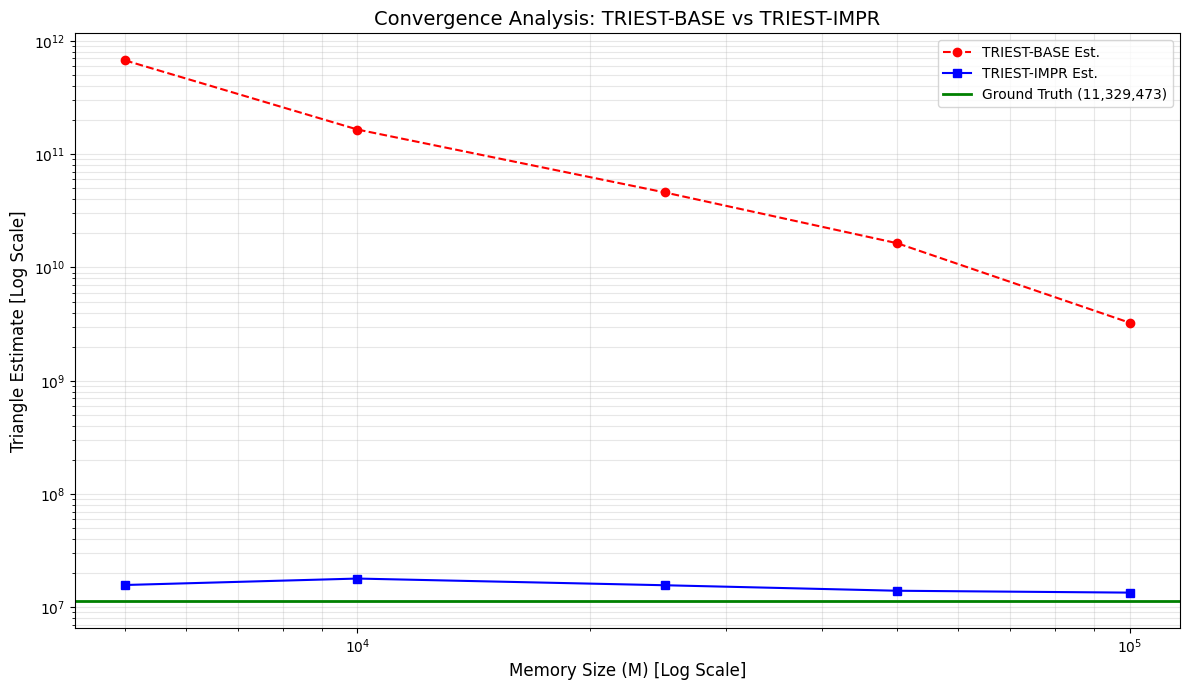

In [8]:
import matplotlib.pyplot as plt
import time

# --- Experiment Configuration ---
# Test different M values to observe how estimates converge to Ground Truth
M_values = [5000, 10000, 25000, 50000, 100000]
file_path = 'data/web-Stanford.txt'
ground_truth = 11329473

results_base = []
results_impr = []

print(f"Starting parametric analysis on M: {M_values}")
print(f"Reading file: {file_path}")

# --- Execution Loop ---
for M in M_values:
    start_time = time.time()
    print(f"Running with M = {M}...", end=" ")
    
    t_base = TriestBase(M)
    t_impr = TriestImpr(M)
    
    # Custom processing loop (suppressing intermediate prints for cleaner output)
    try:
        with open(file_path, 'r') as f:
            for line in f:
                if line.startswith('#'): continue
                parts = line.split()
                if len(parts) < 2: continue
                try:
                    u, v = int(parts[0]), int(parts[1])
                except ValueError: continue
                if u == v: continue
                
                # Canonicalize edge
                if u > v: u, v = v, u
                
                t_base.process_edge(u, v)
                t_impr.process_edge(u, v)
                
    except FileNotFoundError:
        print("Error: File not found!")
        break

    est_base = t_base.get_estimation()
    est_impr = t_impr.get_estimation()
    
    results_base.append(est_base)
    results_impr.append(est_impr)
    
    elapsed = time.time() - start_time
    print(f"Done in {elapsed:.2f}s. \n   -> Base: {int(est_base):,} | Impr: {int(est_impr):,}")

# --- Plotting Results ---
plt.figure(figsize=(12, 7))

# Plot Base and Impr
plt.plot(M_values, results_base, marker='o', label='TRIEST-BASE Est.', color='red', linestyle='--')
plt.plot(M_values, results_impr, marker='s', label='TRIEST-IMPR Est.', color='blue', linestyle='-')

# Plot Ground Truth
plt.axhline(y=ground_truth, color='green', linestyle='-', linewidth=2, label=f'Ground Truth ({ground_truth:,})')

# Axis Configuration
plt.xscale('log') # Log scale to visualize orders of magnitude for M
plt.yscale('log') # Log scale needed because Base error can be massive

plt.xlabel('Memory Size (M) [Log Scale]', fontsize=12)
plt.ylabel('Triangle Estimate [Log Scale]', fontsize=12)
plt.title('Convergence Analysis: TRIEST-BASE vs TRIEST-IMPR', fontsize=14)
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

## Questions

### 1. What were the challenges you faced when implementing the algorithm?

The main challenge we faced was related to duplicate edges and state mismatch.
The  challenge was a `KeyError` during the processing of the `web-Stanford.txt` dataset. This happened because the dataset contains reciprocal edges (e.g., $A \to B$ and $B \to A$). Our notebook canonicalized these to undirected edges ($A-B$), creating *duplicates* in the stream.
   * **The Bug:** Our `ReservoirSampling` class used a `list` and correctly stored multiple copies of the same edge. However, our adjacency list (`self.adj`) used a `set`, which only stored one copy. When the *first* duplicate edge was evicted, it was correctly removed from `self.adj`. When the *second* duplicate edge was evicted later, the code tried to `.remove()` the edge from `self.adj` again, but it was already gone, causing a crash.
   * **The Fix:** We replaced `.remove()` with `.discard()`, which safely does nothing if the item is already gone.


### 2. Can the algorithm be easily parallelized? If yes, how? If not, why? Explain.

No, the algorithm is not easily parallelized because it is inherently sequential.

The core logic of a streaming algorithm relies on its state at time $t$ being a function of its state at time $t-1$. This creates a strong dependency that resists parallel processing.

* **Sequential Dependency:** The sampling decision for the $t$-th edge depends on the value $t$ (e.g., `random.random() < M/t`). If you split the stream into two chunks and process them on different cores, the second core would restart its $t$ from 1, making its probabilities incorrect (e.g., $M/1$ instead of $M/1000001$).
* **State Dependency:** The contents of the reservoir $\mathcal{S}$ at time $t$ depend on every single sampling decision made before it. The second core would have no knowledge of the reservoir $\mathcal{S}$ built by the first core.
* **Partial Parallelism:** While the *stream* processing is sequential, the *work* done for each edge *could* be partially parallelized. For example, the `get_common_neighbors(u, v)` function (which intersects two lists of neighbors) is the main bottleneck. This specific set intersection could be optimized or run on parallel hardware. However, the algorithm would still have to process the stream one edge at a time.

### 3. Does the algorithm work for unbounded graph streams? Explain.

Yes, absolutely. This is the primary strength and purpose of using Reservoir Sampling.

The algorithm is designed to handle a stream of unknown (and potentially infinite) length with a *fixed* amount of memory $M$.

* **Fixed Memory:** The algorithm's memory usage is $O(M)$, regardless of how many edges $t$ have been processed.
* **Adapting Probability:** The sampling probability $p = M/t$ automatically adapts. As the stream grows (i.g., $t \to \infty$), the probability of sampling any *new* edge approaches zero, but it never *is* zero.
* **Contrast with Fixed-Probability:** This is superior to the "fixed-probability" sampling (e.g., "sample every edge with $p=0.01$") mentioned in the paper. In that model, the sample size grows linearly with the stream ($0.01 \times t$) and would eventually exhaust all memory on an unbounded stream. TRIÈST avoids this by fixing the memory $M$ and letting the probability $p$ adapt.

### 4. Does the algorithm support edge deletions? If not, what modification would it need? Explain.

The two algorithms we implemented, TRIÈST-BASE and TRIÈST-IMPR, do not support edge deletions.

* **Why Not:** They are designed for "insertion-only" streams. Their entire mathematical framework (the scaling factor $\xi^{(t)}$ and weight $\eta^{(t)}$) is based on the assumption that the stream size $t$ is always growing. A deletion would break this math and the unbiased nature of the estimator.

* **What Modification is Needed:** To support deletions, we would need to implement a completely different algorithm, which the paper provides in **Section 4.3: TRIÈST-FD (Fully-Dynamic)**.

* **How TRIÈST-FD Works:**
    1.  It replaces standard Reservoir Sampling with a more complex scheme called **Random Pairing (RP)**.
    2.  It maintains special counters for "uncompensated deletions." When an edge `(-, e)` arrives, if $e$ is in the sample, it's removed and a counter $d_i$ (deletion *in* sample) is incremented. If $e$ is *not* in the sample, a counter $d_o$ (deletion *out* of sample) is incremented.
    3.  When a new edge `(+, e)` arrives, it doesn't just face the $M/t$ probability. It might instead be used to "compensate" for a past deletion by filling the "hole" in the sample, which uses a different probability calculation.

In short: No, the versions we built cannot handle deletions. The paper *does* provide a solution, but it requires swapping out the entire sampling algorithm (Reservoir Sampling) for a more complex one (Random Pairing).